In [43]:
"""Please refer to the report if there is anything unclear"""
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import pandas as pd 
import numpy as np

csv_data = '/content/drive/MyDrive/Colab Notebooks/ML lab/Lab6/data/train.csv'
train_df = pd.read_csv(csv_data, sep='\t')

In [45]:
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0
...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0


In [46]:
train_df['votes_up/votes_all'] = train_df['votes_up']/train_df['votes_all']

In [47]:
t = train_df.sort_values(by=['reviewerID'])
t

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,votes_up/votes_all
39574,50,49224,"In 2004, my dream of a Red Sox World Champions...",3.0,35,45,0,0.777778
340,50,36649,"Seriously, Allesandra Torressini (sic) is gorg...",3.0,4,9,0,0.444444
28368,50,44664,"This documentary uses 911 calls, interviews wi...",5.0,85,91,1,0.934066
15054,50,24475,"Let's see, where to start?1. Nero's parents c...",1.0,37,41,1,0.902439
51199,50,46380,WARNING: SPOILERS AHEAD!!I really enjoyed the ...,1.0,24,176,0,0.136364
...,...,...,...,...,...,...,...,...
5884,123767,48875,We all wear a mask. Everyday we put on our ma...,4.0,14,16,0,0.875000
26342,123767,49624,Mardock Scramble has been a great ride... It'...,5.0,12,13,1,0.923077
39905,123767,46943,Mawaru Penguindrum is a difficult anime to def...,5.0,38,43,0,0.883721
45290,123767,48302,"When I started watching Another, I was intrigu...",3.0,12,26,0,0.461538


In [48]:
# extract features from reviewerID
pd.options.mode.chained_assignment = None

reviewerID = set(train_df['reviewerID'])
train_df['reviewer_quality'] = 1
for id in reviewerID:
  numOfreviews = len(train_df.loc[train_df['reviewerID'] == id])
  tot = (train_df.loc[train_df['reviewerID'] == id,'votes_up/votes_all']).sum()
  train_df.loc[train_df['reviewerID']==id, 'reviewer_quality'] = tot/numOfreviews

In [49]:
# extract features from productID
asin = set(train_df['asin'])
train_df['asin_score'] = 1
for id in asin:
  numOfreviews = len(train_df.loc[train_df['asin']==id])
  tot = (train_df.loc[train_df['asin'] == id,'overall']).sum()
  train_df.loc[train_df['asin']==id, 'asin_score'] = tot/numOfreviews

In [50]:
print(train_df)

       reviewerID   asin  ... reviewer_quality  asin_score
0            7885   3901  ...         0.787554    3.400000
1           52087  47978  ...         0.690965    2.500000
2            5701   3667  ...         0.504605    4.000000
3           47191  40892  ...         0.323626    3.000000
4           40957  15367  ...         0.383730    4.375000
...           ...    ...  ...              ...         ...
57034       58315  29374  ...         0.627676    2.952381
57035       23328  45548  ...         0.943871    5.000000
57036       27203  42453  ...         0.643663    3.000000
57037       33992  44891  ...         0.893687    5.000000
57038       27478  19198  ...         0.748503    2.000000

[57039 rows x 10 columns]


In [51]:
y = train_df['label']
y

0        0
1        0
2        1
3        0
4        0
        ..
57034    0
57035    0
57036    0
57037    0
57038    1
Name: label, Length: 57039, dtype: int64

In [52]:
# import packages
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import copy
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
RANDOM_SEED = 2022

In [53]:
# extract features from reviewText
from textblob import TextBlob

train_df['polarity'] = train_df['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
train_df['subjectivity'] = train_df['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [54]:
# extract key terms from reviewText using Latent Semantic Analysis
from sklearn.decomposition import TruncatedSVD
train_df['tfidf'] = 0

tv = TfidfVectorizer()
reviewerText_tfidf = tv.fit_transform(train_df['reviewText'])
train_df['tfidf'] = TruncatedSVD(n_components=100).fit_transform(reviewerText_tfidf)

In [55]:
# word count of the reviewText
train_df['word_count'] = train_df['reviewText'].str.replace('[^\w\s]',' ').str.split().str.len()

In [56]:
train_df

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label,votes_up/votes_all,reviewer_quality,asin_score,polarity,subjectivity,tfidf,word_count
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0,0.857143,0.787554,3.400000,0.198494,0.598768,0.366072,427
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0,0.738806,0.690965,2.500000,0.030000,0.503526,0.445766,490
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1,1.000000,0.504605,4.000000,0.221667,0.575000,0.227014,70
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0,0.571429,0.323626,3.000000,-0.106471,0.447059,0.201599,117
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0,0.500000,0.383730,4.375000,0.037500,0.425000,0.214082,111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57034,58315,29374,"If you like beautifully shot, well acted films...",2.0,12,21,0,0.571429,0.627676,2.952381,0.206563,0.649167,0.513759,476
57035,23328,45548,This is a great set of films Wayne did Fox and...,5.0,15,18,0,0.833333,0.943871,5.000000,0.086667,0.498889,0.155535,325
57036,27203,42453,It's what's known as a comedy of manners. It's...,3.0,4,5,0,0.800000,0.643663,3.000000,0.147941,0.427894,0.459087,389
57037,33992,44891,Ellen can do no wrong as far a creating wonder...,5.0,4,5,0,0.800000,0.893687,5.000000,0.194481,0.739935,0.177156,72


In [57]:
train_df.describe()

,reviewerID,asin,overall,votes_up,votes_all,label,votes_up/votes_all,reviewer_quality,asin_score,polarity,subjectivity,tfidf,word_count
count,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000,57039.000000
mean,33359.761865,19973.170866,3.535178,12.387594,18.475850,0.226196,0.633393,0.633393,3.535178,0.142922,0.523320,0.317424,261.537089
std,30016.804127,14104.410152,1.529742,45.130499,50.149683,0.418371,0.293271,0.183564,1.043700,0.168948,0.109660,0.105733,249.083675
min,50.000000,0.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.002001,1.000000
25%,9235.000000,8218.000000,2.000000,4.000000,6.000000,0.000000,0.400000,0.511988,2.937500,0.055556,0.463565,0.244309,102.000000
50%,22589.000000,17635.000000,4.000000,6.000000,10.000000,0.000000,0.692308,0.655551,3.590164,0.144489,0.521053,0.315955,191.000000
75%,53170.000000,30875.000000,5.000000,11.000000,18.000000,0.000000,0.880000,0.774452,4.333333,0.234363,0.581667,0.388603,334.000000
max,123767.000000,50051.000000,5.000000,6084.000000,6510.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,0.751265,4472.000000


In [58]:
csv_data = '/content/drive/MyDrive/Colab Notebooks/ML lab/Lab6/data/test.csv'
test_df = pd.read_csv(csv_data, sep='\t') 

In [59]:
test_df.head()

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0


In [60]:
test_df['polarity'] = test_df['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
test_df['subjectivity'] = test_df['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [61]:
reviewerID_test = set(test_df['reviewerID'])
test_df['reviewer_quality'] = 1
for id in reviewerID_test:
  if id in reviewerID:
    test_df.loc[test_df['reviewerID']==id, 'reviewer_quality'] = train_df.loc[train_df['reviewerID']==id, 'reviewer_quality'].iloc[0]
  else:
    # set 'reviewer_quality' as 0.5 since we know nothing about the reviewer in the test set
    test_df.loc[test_df['reviewerID']==id, 'reviewer_quality'] =  0.5


In [62]:
asin_test = set(test_df['asin'])
test_df['asin_score'] = 1
for id in asin_test:
  if id in asin:
    numOfreviews = len(train_df.loc[train_df['asin']==id]) + len(train_df.loc[train_df['asin']==id])
    tot = (train_df.loc[train_df['asin'] == id,'overall']).sum() + (test_df.loc[test_df['asin'] == id,'overall']).sum()
    test_df.loc[test_df['asin']==id, 'asin_score'] = tot/numOfreviews
  else:
    # an unknown product
    numOfreviews = len(test_df.loc[test_df['asin']==id])
    tot = (test_df.loc[test_df['asin'] == id,'overall']).sum()
    test_df.loc[test_df['asin']==id, 'asin_score'] = tot/numOfreviews

In [63]:
# extract key terms from reviewText using Latent Semantic Analysis
test_df['tfidf'] = 0

tv = TfidfVectorizer()
reviewerText_tfidf = tv.fit_transform(test_df['reviewText'])
test_df['tfidf'] = TruncatedSVD(n_components=100).fit_transform(reviewerText_tfidf)

In [64]:
# word count of the reviewText
test_df['word_count'] = test_df['reviewText'].str.replace('[^\w\s]',' ').str.split().str.len()

In [65]:
test_df = test_df.drop(columns=['Id','reviewText','reviewerID','asin'])
test_df

,overall,polarity,subjectivity,reviewer_quality,asin_score,tfidf,word_count
0,1.0,0.200000,0.200000,0.714387,3.500000,0.168579,39
1,4.0,0.296491,0.537719,0.664652,1.840909,0.388871,176
2,3.0,0.016857,0.575482,0.820801,1.950000,0.380354,350
3,5.0,0.333766,0.707143,0.821905,3.750000,0.245598,71
4,5.0,0.246667,0.313333,0.720728,3.000000,0.165415,82
...,...,...,...,...,...,...,...
11203,5.0,0.176799,0.444806,0.627646,2.452381,0.623344,880
11204,5.0,0.038636,0.657576,0.400000,2.758065,0.238391,97
11205,5.0,0.065549,0.535520,0.429831,3.750000,0.561506,5458
11206,5.0,0.151197,0.509484,0.952250,3.416667,0.442397,596


In [66]:
# drop columns and reorder
train_df1 = train_df.drop(columns=['reviewText','votes_up','votes_all','votes_up/votes_all','label','reviewerID', 'asin'])
X = train_df1[['overall','polarity','subjectivity','reviewer_quality','asin_score','tfidf','word_count']]

In [25]:
X

,overall,polarity,subjectivity,reviewer_quality,asin_score,tfidf,word_count
0,5.0,0.198494,0.598768,0.787554,3.400000,0.366072,427
1,3.0,0.030000,0.503526,0.690965,2.500000,0.445766,490
2,4.0,0.221667,0.575000,0.504605,4.000000,0.227014,70
3,1.0,-0.106471,0.447059,0.323626,3.000000,0.201599,117
4,5.0,0.037500,0.425000,0.383730,4.375000,0.214082,111
...,...,...,...,...,...,...,...
57034,2.0,0.206563,0.649167,0.627676,2.952381,0.513759,476
57035,5.0,0.086667,0.498889,0.943871,5.000000,0.155535,325
57036,3.0,0.147941,0.427894,0.643663,3.000000,0.459087,389
57037,5.0,0.194481,0.739935,0.893687,5.000000,0.177156,72


In [26]:
x_train, x_validate, y_train, y_validate = train_test_split(X.values, y, train_size=0.8, random_state=RANDOM_SEED)
x_train.shape, y_train.shape

((45631, 7), (45631,))

In [27]:
# Bagging Algorithm
class BaggingClassifier(object):
  def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap_size=0.8):
    self.base_estimator_ = base_estimator
    self.n_estimators_ = n_estimators
    self.bootstrap_size_ = bootstrap_size
    self.estimators_ = [None]*self.n_estimators_
  
  def fit(self, X, y):
    y = np.array(y)
    for t in range(self.n_estimators_):
      # 1. sample N instances with replacement from the original training set
      D, not_D, labels_in_D, labels_in_not_D = train_test_split(X,y,train_size=self.bootstrap_size_,shuffle=True)
      # 2. apply the learning algorithm to the sample
      Ct = copy.deepcopy(self.base_estimator_)
      Ct.fit(D, labels_in_D)
      # 3. store the resulting classifier
      self.estimators_[t] = Ct

  def predict_proba(self, X):
    y_prob_temp = []
    for t in range(self.n_estimators_):
      # predict class of instance using classifier
      y_prob_temp.append(self.estimators_[t].predict_proba(X)[:,1])
    y_prob_temp = np.array(y_prob_temp)
    return [self._vote(y_prob_temp[:,i]) for i in range(X.shape[0])]

  # equal vote
  def _vote(self, y_prob_temp):
    y_prob = y_prob_temp.sum()/len(y_prob_temp)
    return y_prob


In [28]:
# Adaptive Boosting Algorithm

class AdaBoostM1Classifier(object):
  def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10, bootstrap_size=0.6):
    self.base_estimator_ = base_estimator
    self.n_estimators_ = n_estimators
    self.weights_ = None
    self.Beta_ = np.ones(self.n_estimators_)
    self.estimators_ = [None]*self.n_estimators_
    self.bootstrap_size_ = bootstrap_size

  def fit(self, X, y):
    y = np.array(y)
    # 1. initialize the observation weights 
    self.weights_ = np.ones(X.shape[0])/X.shape[0]
    for t in range(self.n_estimators_):
      D, not_D, labels_in_D, labels_in_not_D = train_test_split(X,y,train_size=self.bootstrap_size_,shuffle=True)
      Ct = copy.deepcopy(self.base_estimator_)
      Ct.fit(D, labels_in_D)
      self.estimators_[t] = Ct
      pred = self.estimators_[t].predict(not_D)
      # 2. compute the error
      err = self._compute_error(labels_in_not_D, pred)
      if err > 0.5: raise error("Please choose a better Classifier")
      elif err == 0: 
        self.Beta_[t] = 1
        # self.Beta_ = self.Beta_[:t+1]
        # self.n_estimators_= t+1
      # 3. compute the beta value
      else: self.Beta_[t] = np.log(err/(1-err))
      # 4. update the weight of every sample point
      indices = np.where(pred == labels_in_not_D)
      self.weights_[indices] = self.weights_[indices]*np.exp(self.Beta_[t])
      # 5. normalize
      self.weights_ = self.weights_/self.weights_.sum()

  def predict_proba(self, X):
    y_prob_temp = []
    for t in range(self.n_estimators_):
      # predict class of instance using classifier
      y_prob_temp.append(self.estimators_[t].predict_proba(X)[:,1])
    y_prob_temp = np.array(y_prob_temp)
    return [self._vote(y_prob_temp[:,i]) for i in range(X.shape[0])]

  # weighted vote
  def _vote(self, y_prob_temp):
    y_prob = 0
    for t in range(self.n_estimators_):
      # y = np.dot(np.log(1/self.Beta_[t]),y_temp)
      # print(self.Beta_[t])
      # print(y_temp[t])
      y_prob += np.log(1/np.exp(self.Beta_[t]))*y_prob_temp[t]
    return y_prob

  def _compute_error(self, y, pred):
    y = np.array(y)
    pred = np.array(pred)
    indices = np.where(pred!=y)
    return self.weights_[indices].sum()



In [39]:
# base estimator scores before boosting
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
pred = dt.predict_proba(x_validate)
print("roc_auc_score: ", roc_auc_score(y_validate, pred[:,1]))

roc_auc_score:  0.6372609824305632


In [40]:
svc = CalibratedClassifierCV(LinearSVC(dual=False))
svc.fit(x_train, y_train)
pred = svc.predict_proba(x_validate)
print("roc_auc_score: ", roc_auc_score(y_validate, pred[:,1]))

roc_auc_score:  0.8204978025664775


In [36]:
# Bagging + DecisionTree
Bagging_DT = BaggingClassifier(n_estimators=30)
Bagging_DT.fit(x_train, y_train)
pred_1 = Bagging_DT.predict_proba(x_validate)
predictions = [pred_1]
print("roc_auc_score: ", roc_auc_score(y_validate,pred_1))

roc_auc_score:  0.7982890447099421


In [35]:
# Bagging + SVM
Bagging_SVM = BaggingClassifier(base_estimator=CalibratedClassifierCV(LinearSVC(dual=False)),n_estimators=30)
Bagging_SVM.fit(x_train, y_train)
pred_2 = Bagging_SVM.predict_proba(x_validate)
predictions.append(pred_2)
print("roc_auc_score: ", roc_auc_score(y_validate, pred_2))

roc_auc_score:  0.8204877265842087


In [ ]:
# AdaBoost.M1 + DecisionTree
AdaBoost_DT = AdaBoostM1Classifier(n_estimators=30)
AdaBoost_DT.fit(x_train, y_train)
pred_3 = AdaBoost_DT.predict_proba(x_validate)
predictions.append(pred_3)
print("roc_auc_score: ", roc_auc_score(y_validate, pred_3))

roc_auc_score:  0.7936565449858056


In [ ]:
# AdaBoost.M1 + SVM
AdaBoost_SVM = AdaBoostM1Classifier(base_estimator=CalibratedClassifierCV(LinearSVC(dual=False)),n_estimators=30)
AdaBoost_SVM.fit(x_train, y_train)
pred_4 = AdaBoost_SVM.predict_proba(x_validate)
predictions.append(pred_4)
print("roc_auc_score: ", roc_auc_score(y_validate, pred_4))

roc_auc_score:  0.8205133623798042


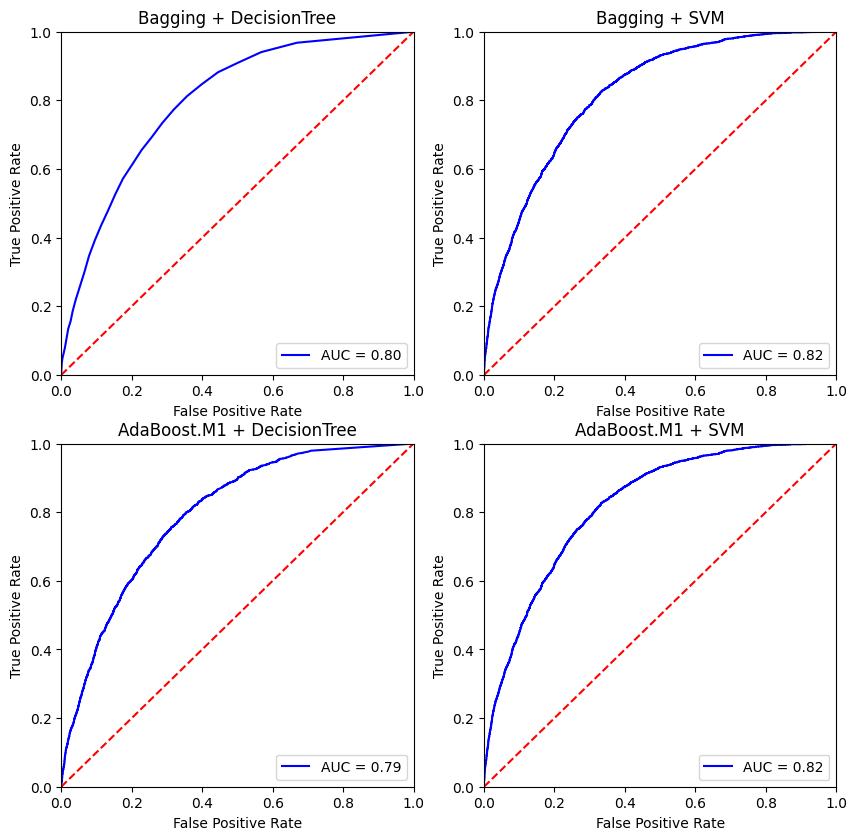

In [ ]:
import sklearn.metrics as metrics

fig, axes = plt.subplots(2,2,figsize=(10,10),dpi=100)
ax = axes.flatten()
titles = ["Bagging + DecisionTree","Bagging + SVM", "AdaBoost.M1 + DecisionTree", "AdaBoost.M1 + SVM"]
for i in range(4):
  # calculate the fpr and tpr for all thresholds of the classification
  fpr, tpr, threshold = metrics.roc_curve(y_validate, predictions[i])
  roc_auc = metrics.auc(fpr, tpr)
  # plot the roc_auc curve
  ax[i].set_title(titles[i])
  ax[i].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax[i].legend(loc = 'lower right')
  ax[i].plot([0, 1], [0, 1],'r--')
  ax[i].set_xlim([0, 1])
  ax[i].set_ylim([0, 1])
  ax[i].set_ylabel('True Positive Rate')
  ax[i].set_xlabel('False Positive Rate')

plt.show()

roc_auc_score:  0.8204966433826768
roc_auc_score:  0.8204663262678852
roc_auc_score:  0.8204842936167984
roc_auc_score:  0.8204542885899533
roc_auc_score:  0.8204780518578708
roc_auc_score:  0.8204998534301252
roc_auc_score:  0.8204661925159079
roc_auc_score:  0.8204582119812791
roc_auc_score:  0.8204748863944146
roc_auc_score:  0.8204718992669279
roc_auc_score:  0.8204760901622077
roc_auc_score:  0.820454779013869
roc_auc_score:  0.8204963312947304
roc_auc_score:  0.8204667275238162
roc_auc_score:  0.8204686892194792
roc_auc_score:  0.8204811727373346
roc_auc_score:  0.8204795231296179
roc_auc_score:  0.8204742176345294
roc_auc_score:  0.8204625366285362
roc_auc_score:  0.8204716317629737


Text(0.5, 1.0, 'scores against # of estimators')

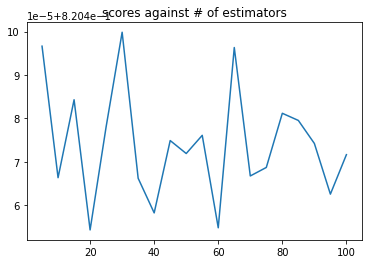

In [ ]:
# parameter tuning for ensemble learning
# Bagging - # of estimators
n_estimators = [5*i for i in range(1,21)]
scores = []
for n in n_estimators:
  Bagging_DT = BaggingClassifier(base_estimator=CalibratedClassifierCV(LinearSVC(dual=False)),n_estimators=n)
  Bagging_DT.fit(x_train, y_train)
  pred = Bagging_DT.predict_proba(x_validate)
  score = roc_auc_score(y_validate, pred)
  scores.append(score)
  print("roc_auc_score: ", score)

plt.plot(n_estimators, scores)
plt.title("scores against # of estimators")

roc_auc_score:  0.8256074178846456
roc_auc_score:  0.827654447308966
roc_auc_score:  0.8249504504655126
roc_auc_score:  0.824875103518457
roc_auc_score:  0.823349372424578
roc_auc_score:  0.8225851582118698
roc_auc_score:  0.8224162740488841
roc_auc_score:  0.8184204783193619
roc_auc_score:  0.8188279760093538
roc_auc_score:  0.818453894021621
roc_auc_score:  0.8174399871598103
roc_auc_score:  0.8142605912060306
roc_auc_score:  0.8114740248087625
roc_auc_score:  0.8123585712167974
roc_auc_score:  0.8091849043060334
roc_auc_score:  0.8079795760731088
roc_auc_score:  0.8040727254083058
roc_auc_score:  0.8025938075063839
roc_auc_score:  0.7940240062506757


Text(0.5, 1.0, 'scores against bootstrap_size')

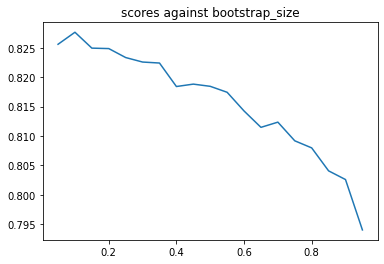

In [ ]:
# Bagging - bootstrap size
bootstrap_sizes = [5*i/100 for i in range(1,20)]
scores = []
for frac in bootstrap_sizes:
  Bagging_DT = BaggingClassifier(n_estimators=n, bootstrap_size=frac)
  Bagging_DT.fit(x_train, y_train)
  pred = Bagging_DT.predict_proba(x_validate)
  score = roc_auc_score(y_validate, pred)
  scores.append(score)
  print("roc_auc_score: ", score)

plt.plot(bootstrap_sizes, scores)
plt.title("scores against bootstrap_size")

In [ ]:
# parameter tuning for ensemble learning
# AdaBoost.M1
n_estimators = [5*i for i in range(1,9)]
scores = []
for n in n_estimators:
  AdaBoost_DT = AdaBoostM1Classifier(n_estimators=n)
  AdaBoost_DT.fit(x_train, y_train)
  pred = AdaBoost_DT.predict_proba(x_validate)
  score = roc_auc_score(y_validate, pred)
  scores.append(score)
  print("roc_auc_score: ", score)

roc_auc_score:  0.747656431296625
roc_auc_score:  0.7795770985406545
roc_auc_score:  0.7871630202533931
roc_auc_score:  0.7926838560249135
roc_auc_score:  0.7898035071997576
roc_auc_score:  0.7950696346230368
roc_auc_score:  0.7927690560342762
roc_auc_score:  0.7968681528740513


roc_auc_score:  0.8074770476034433


Text(0.5, 1.0, 'scores against # of estimators')

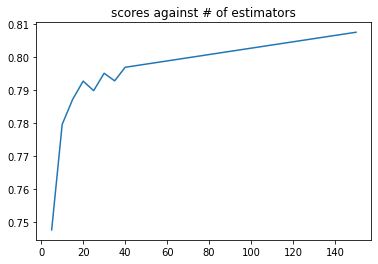

In [ ]:
# The float precision somestimes unable to hold the value of beta, and it's kinda a matter of luck...
n = 150
AdaBoost_DT = AdaBoostM1Classifier(n_estimators=n)
AdaBoost_DT.fit(x_train, y_train)
pred = AdaBoost_DT.predict_proba(x_validate)
score = roc_auc_score(y_validate, pred)
print("roc_auc_score: ", score)
n_estimators.append(n)
scores.append(score)


plt.plot(n_estimators, scores)
plt.title("scores against # of estimators")

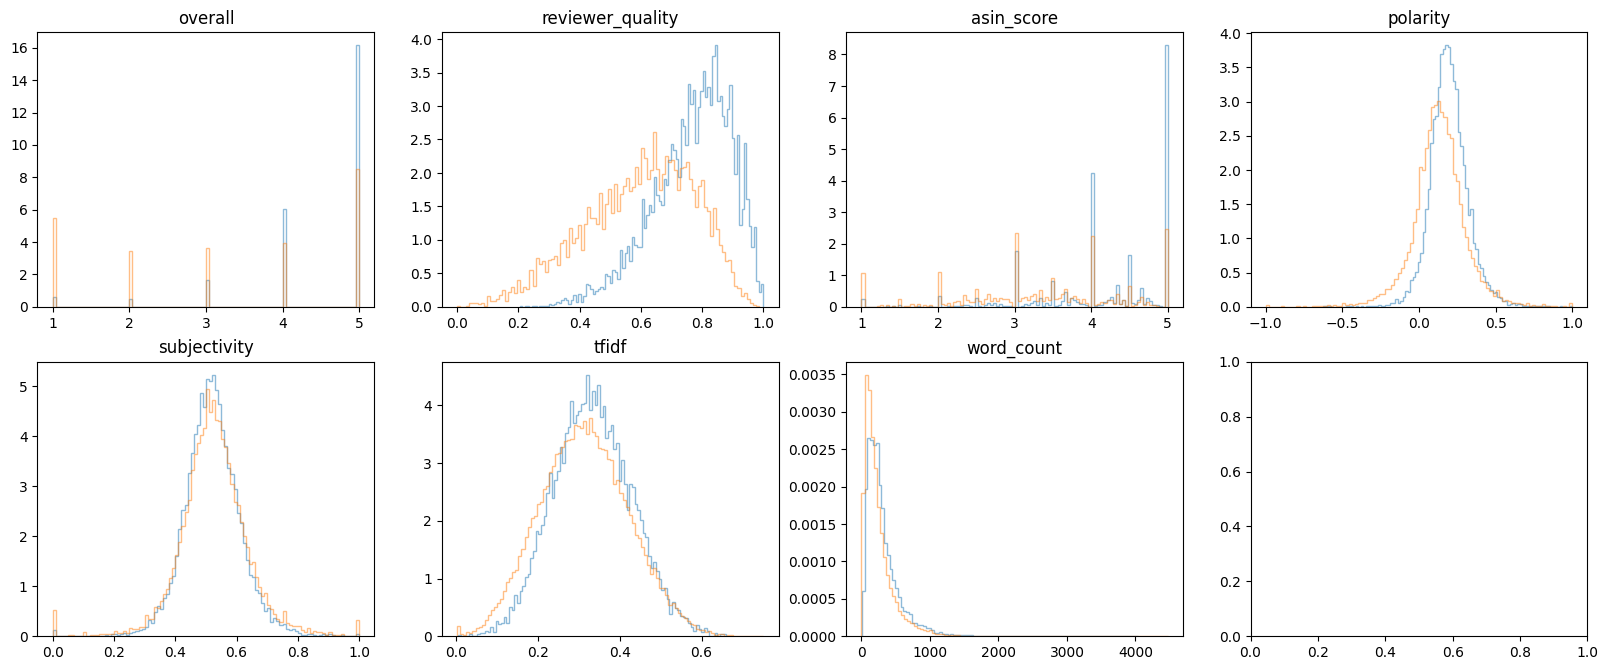

In [67]:
# feature analysis
feature_names = ['overall','reviewer_quality','asin_score','polarity','subjectivity','tfidf','word_count']
fig, axes = plt.subplots(2,4,figsize=(20,8),dpi=100)
ax = axes.flatten()
for i, c in enumerate(feature_names):
  ax[i].hist(train_df[c][train_df['label']==1],bins=100,alpha=0.5,histtype='step',cumulative=False,density=True,label='1')
  ax[i].hist(train_df[c][train_df['label']==0],bins=100,alpha=0.5,histtype='step',cumulative=False,density=True,label='0')
  ax[i].set_title(c,fontsize=15)
  ax[i].set_title(c)

plt.show()

In [68]:
# using other classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB
from sklearn.linear_model import LogisticRegression

In [69]:
# Bagging + KNN 
Bagging_knn = BaggingClassifier(base_estimator=KNeighborsClassifier())
Bagging_knn.fit(x_train, y_train)
pred = Bagging_knn.predict_proba(x_validate)
print("KNN roc_auc_score: ", roc_auc_score(y_validate, pred))

KNN roc_auc_score:  0.7355060896160539


In [71]:
# Bagging + Naive Bayes
# Shift the `polarity` values to make it positive in order to feed into Naive Bayes models
df = copy.deepcopy(train_df)
df['polarity'] = df['polarity'] + 1
X_temp = df.drop(columns=['reviewText','votes_up','votes_all','votes_up/votes_all','label','reviewerID', 'asin'])
x_train1, x_validate1, y_train1, y_validate1 = train_test_split(X_temp.values, train_df['label'], train_size=0.8, random_state=RANDOM_SEED)


Bagging_mnb = BaggingClassifier(base_estimator=MultinomialNB())
Bagging_mnb.fit(x_train1, y_train1)
pred = Bagging_mnb.predict_proba(x_validate1)
print("MultinomialNB roc_auc_score: ", roc_auc_score(y_validate1, pred))


Bagging_mnb = BaggingClassifier(base_estimator=BernoulliNB())
Bagging_mnb.fit(x_train1, y_train1)
pred = Bagging_mnb.predict_proba(x_validate1)
print("BernoulliNB roc_auc_score: ", roc_auc_score(y_validate1, pred))


Bagging_mnb = BaggingClassifier(base_estimator=ComplementNB())
Bagging_mnb.fit(x_train1, y_train1)
pred = Bagging_mnb.predict_proba(x_validate1)
print("ComplementNB roc_auc_score: ", roc_auc_score(y_validate1, pred))

MultinomialNB roc_auc_score:  0.7157592598165592
BernoulliNB roc_auc_score:  0.5015972438175935
ComplementNB roc_auc_score:  0.7141431792622017


In [ ]:
########### Final Model ###############
n=500
Bagging_DT = BaggingClassifier(base_estimator=CalibratedClassifierCV(LinearSVC(dual=False)),n_estimators=100, bootstrap_size=0.05)
Bagging_DT.fit(X.values, y)
test_pred = Bagging_DT.predict_proba(test_df.values)

In [ ]:
import csv
result_path = '/content/drive/MyDrive/Colab Notebooks/ML lab/Lab6/result.csv'
with open(result_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Predicted"])
    for i in range(len(test_pred)):
      writer.writerow([i, test_pred[i]])